# Where do characters spend their time?

For this part, I want to examine which characters can be found where in each series.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

episodes = pd.read_csv('episode_index.csv', index_col=['series','episode'])
lines = pd.read_csv('table_of_lines.csv')

You'd probably guess that the Bridge is the most common location in all six series, to varying degrees. But presumably some characters spend more time there than others. Let's make a heat map showing where the characters with the most lines in each series say those lines. As a start, we can pivot into a table indexed by characters, with scene locations as columns, counting lines. For the moment, let's just do it for TNG, and then we can wrap the whole process up into a function to apply to the other series:

In [2]:
TNG_lines = lines.loc[lines.series=='TNG']
TNG_pivot = TNG_lines.pivot_table(values='line', index='character', 
                                  columns='scene_loc', aggfunc='count').fillna(0).astype('int')
TNG_pivot

scene_loc,11001001 - Bourbon Street Bar,11001001 - Engineering,1701-C Bridge,1701C Bridge,1701D Bridge,221B Baker Street,A Matter Of Honour - Pagh Bridge,Academy Gardens,Academy Hearing Room,Admiral's Quarters,...,Wesley's Room,Woods,Worf's Chamber,Worf's Chambers,Worf's Private Room,Worf's Quarters,Worf's Room,Wyatt's Quarters,Yranac's Quarters,Zorn's Office
character,,,,,,,,,,,,,,,,,,,,,
AARON,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACCOLAN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADMINISTRATOR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADONIS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AIDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AJUR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALANS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALBERT,0,0,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
ALEXANA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Well, that's unwieldy. Let's narrow it down to just the regulars (the 7 characters with the most lines), and the 10 locations with the most lines spoken by those characters.

In [3]:
TNG_pivot['row_sum'] = TNG_pivot.apply(sum, axis=1)
TNG_pivot.sort_values(by='row_sum', ascending=False, inplace=True)
TNG_regulars = TNG_pivot.iloc[:7,:]
TNG_regulars

scene_loc,11001001 - Bourbon Street Bar,11001001 - Engineering,1701-C Bridge,1701C Bridge,1701D Bridge,221B Baker Street,A Matter Of Honour - Pagh Bridge,Academy Gardens,Academy Hearing Room,Admiral's Quarters,...,Woods,Worf's Chamber,Worf's Chambers,Worf's Private Room,Worf's Quarters,Worf's Room,Wyatt's Quarters,Yranac's Quarters,Zorn's Office,row_sum
character,,,,,,,,,,,,,,,,,,,,,
PICARD,0,1,6,1,25,23,0,23,2,15,...,0,0,0,0,27,0,0,0,9,12305
RIKER,4,1,6,1,10,6,5,0,0,0,...,0,0,0,14,22,0,0,12,13,7398
DATA,0,0,0,0,12,27,0,0,0,0,...,0,0,0,0,2,0,0,2,1,6298
LAFORGE,0,0,2,0,0,18,0,0,0,0,...,0,0,0,0,6,0,0,0,0,4573
WORF,0,0,0,0,1,0,0,0,0,0,...,0,3,6,34,180,17,0,0,0,3810
CRUSHER,0,0,2,0,0,0,0,0,1,0,...,0,0,0,6,6,0,0,0,0,3236
TROI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,10,48,0,12,0,3,3214


In [4]:
pd.set_option('max_columns', 11)
TNG_regulars.loc['total'] = TNG_regulars.sum()
TNG_regulars.sort_values(by='total', ascending=False, axis=1, inplace=True)
TNG_regulars_locations = TNG_regulars.iloc[:,:11]
TNG_regulars_locations

scene_loc,row_sum,Bridge,Observation Lounge,Ready Room,Engineering,Sickbay,Ten Forward,Corridor,Transporter Room,Data's Quarters,Picard's Quarters
character,,,,,,,,,,,
PICARD,12305,4012,998,1418,288,476,226,247,272,67,313
RIKER,7398,2471,543,405,250,223,287,221,248,34,40
DATA,6298,1949,375,254,479,127,279,148,100,316,12
LAFORGE,4573,913,298,106,1048,115,227,110,74,82,7
WORF,3810,1473,227,104,79,104,138,119,92,24,13
CRUSHER,3236,354,172,146,54,764,65,68,48,8,116
TROI,3214,394,241,178,24,201,269,178,52,44,26
total,40834,11566,2854,2611,2222,2010,1491,1091,886,575,527


Finally, let's convert these to percentages and generate the heat map using Seaborn.

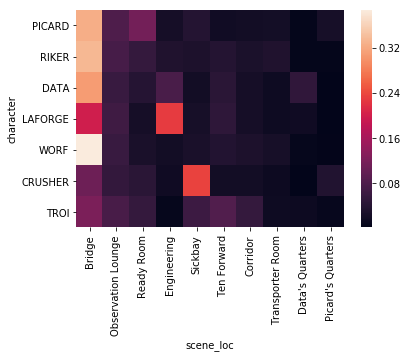

In [5]:
heat_map_table = TNG_regulars_locations.div(TNG_regulars_locations.row_sum, axis=0)
heat_map_table.drop(index=['total'], columns=['row_sum'], inplace=True)
sns.heatmap(heat_map_table)

One obvious thing that could probably be fixed here is that the Bridge clearly dominates for almost everone, to the point where lots of lower values get crunched together into dark purple (and if we capped the color scale lower, we'd just end up with a column of mostly white). Worf, especially, needs to take a vacation already--a fact that is much more obvious (to me, at least) from the heat map than from the pure table of numbers. Here's a second stab at the graph, this time with some cleanup:

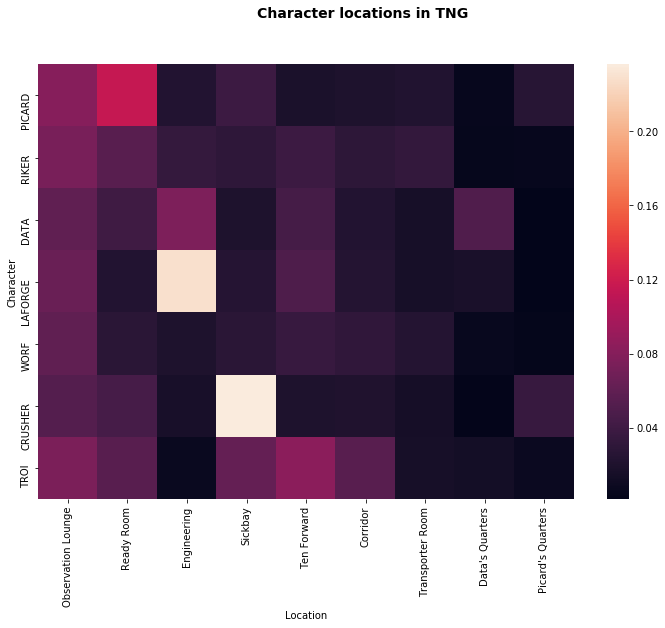

In [6]:
heat_map_table.drop(columns=['Bridge'], inplace=True)
heat_map_table.index.names=['Character']
heat_map_table.columns.names=['Location']
figure, ax = plt.subplots(figsize=(12,8))
plt.suptitle('Character locations in TNG', fontsize=14, fontweight='bold')
sns.heatmap(heat_map_table, ax=ax)

The code for making this plot for the rest of the series is in the hidden cell below (it's basically the last several cells glued together). The next cell produces a set of subplots for all the series.

In [7]:
def character_location_plot(series, size, regulars, locations=10, drop_Bridge=True, ax=None):
    #series: 'TNG', 'TOS', etc.
    #size: ordered pair for size of the axes to draw on
    #regulars: how many characters to keep
    #locations: how many locations to keep, including the Bridge regardless of drop_Bridge
    #drop_bridge: whether to eliminate the Bridge from consideration
    #ax: pass in an Axis to drop the graph into; otherwise, one is created for this plot
    series_lines = lines.loc[lines.series==series]
    series_pivot = series_lines.pivot_table(values='line', index='character', 
                                  columns='scene_loc', aggfunc='count').fillna(0).astype('int')
    series_pivot['row_sum'] = series_pivot.apply(sum, axis=1)
    series_pivot.sort_values(by='row_sum', ascending=False, inplace=True)
    series_regulars = series_pivot.iloc[:regulars,:]
    series_regulars.loc['total'] = series_regulars.sum()
    series_regulars.sort_values(by='total', ascending=False, axis=1, inplace=True)
    series_regulars_locations = series_regulars.iloc[:,:locations+1]
    heat_map_table = series_regulars_locations.div(series_regulars_locations.row_sum, axis=0)
    heat_map_table.drop(index=['total'], columns=['row_sum'], inplace=True)
    if drop_Bridge:
        heat_map_table.drop(columns=['Bridge'], inplace=True)
    if ax==None:
        figure, ax = plt.subplots(figsize=size)
        heat_map_table.index.names=['Character']
        heat_map_table.columns.names=['Location']
    else:
        heat_map_table.index.names=['']
        heat_map_table.columns.names=['']
    g = sns.heatmap(heat_map_table, vmin=0, vmax=0.16, cmap='coolwarm', ax=ax, robust=True)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha='right')
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    g.set_title(series, fontsize=14, fontweight='bold')
    return g

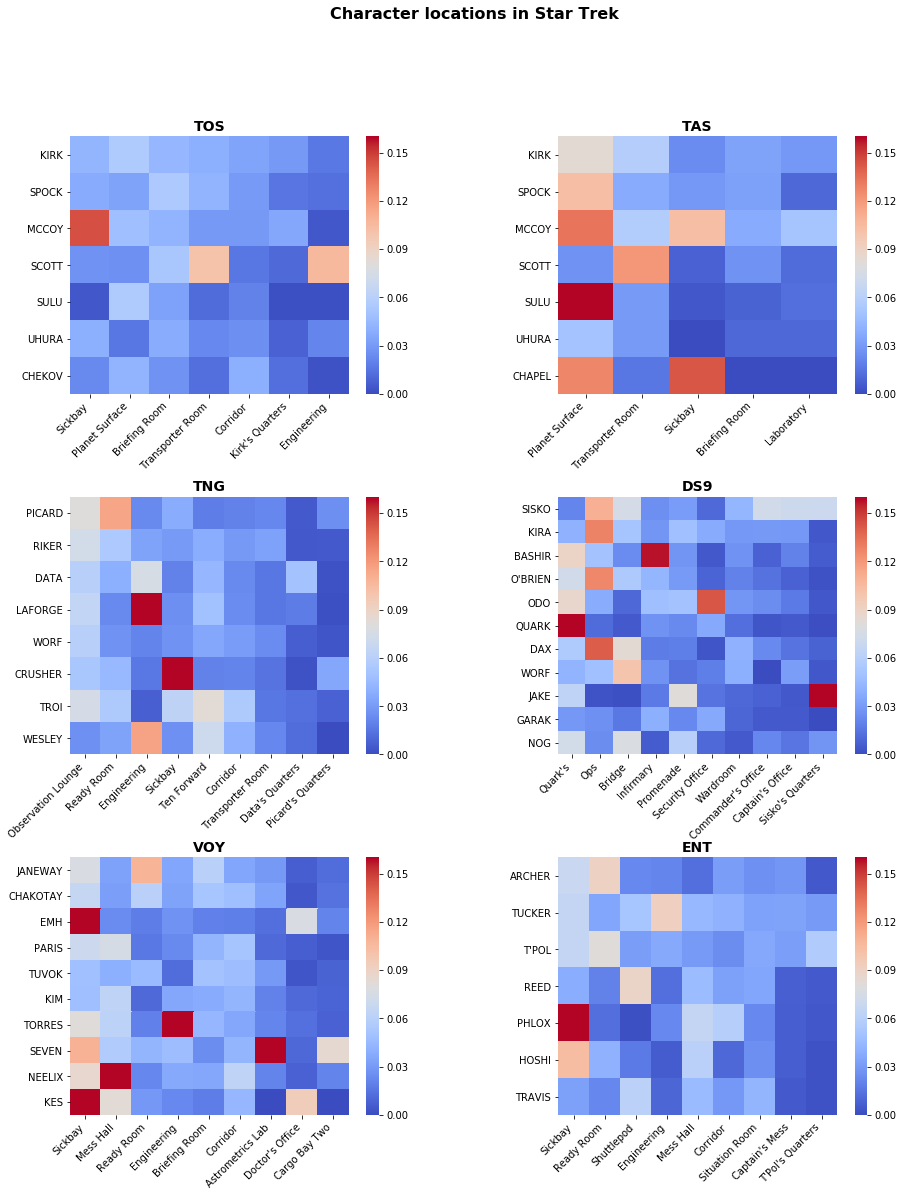

In [8]:
fig, [[ax_TOS, ax_TAS], [ax_TNG, ax_DS9], [ax_VOY, ax_ENT]] = plt.subplots(3,2, figsize=(15,18))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.suptitle('Character locations in Star Trek', fontsize=16, fontweight='bold')
character_location_plot('TOS', (7,6), 7, locations=8, ax=ax_TOS)
character_location_plot('TAS', (7,6), 7, locations=6, ax=ax_TAS)
character_location_plot('TNG', (7,6), 8, ax=ax_TNG)
character_location_plot('DS9', (7,6), 11, drop_Bridge=False, ax=ax_DS9)
character_location_plot('VOY', (7,6), 10, ax=ax_VOY)
character_location_plot('ENT', (7,6), 7, ax=ax_ENT)

There's some fun little tidbits in all of these.

* TOS really leaned on going to see McCoy in Sickbay (it was the most popular non-Bridge location!), but McCoy also got out and about more than any other doctor--all the others max out the scale in Sickbay.
* You can see the imprints of a couple of romances; Kes and Neelix have a neat little reciprocal corner on VOY, and T'Pol's Quarters are dark blue for everyone but T'Pol and Tucker. Ditto Crusher in Picard's Quarters, which is more dubious.
* Troi spends a lot of time in Ten Forward, maybe evidence of the writers not really knowing what to do with her (on the flip side, remember how drunk she got in *First Contact*?).
* ENT's Tucker is really the only engineer to break out of spending tons of time in Engineering.
* VOY really pigeonholed its crew members--five of them spend a scale-breaking amount of time somewhere.